# Colonoscopy polyps detection using small CNN and simple Windows


With a very simple script, it is possible to detect a polyp into a colonoscopy image (this is not the YOLO algorithm!). I will use the previous saved model obtained with simple CNNs.
* Input a colonoscopy image that could contain a polyp
* Load the precalculated model with the small CNN notebook (I used small CNN for simplicity)
* Extract smaller images with shape 150 x 150 x 3 using a sliding window.
* Predict the polyps into these fragments
* Choose the best prediction
* Localize the polyp in the input big picture from colonoscopy.

Let's load the libraries:

In [1]:
import random
import matplotlib.pyplot as plt
import skimage.io
import numpy as np
import os
from keras import *
from keras.models import *
from keras.layers import Input, Dense
from keras.preprocessing import image
from matplotlib.patches import Rectangle

Using TensorFlow backend.


Define the size of the windows egual with the image shape used as input for the CNN model and the step to slide the search windows. Thus, an input image from colonoscopy will be used to extract smaller fragments of `150 x 150 pixels`:

In [2]:
WINDOW_SIZES = [150]      # using only one size for the sliding window
window_sizes=WINDOW_SIZES 
step=10                   # step of sliding on the input image (how to divide the original image)

Read the colonoscopy image where we trying to find a polyp:

In [3]:
img = skimage.io.imread('C:/Users/lenovo/Desktop/Final Project/results/85.tif', plugin='tifffile') # load a test image
print('Input image size=',img.shape[0],img.shape[1])
plt.figure()
plt.imshow(img)
plt.show()
#C:/Users/lenovo/Desktop/Final Project/results/265.tif


FileNotFoundError: [Errno 2] No such file or directory: '/Users/dojo/Desktop/Project/Final Project/C:/Users/lenovo/Desktop/Final Project/results/85.tif'

Load a saved model obtaind with small CNN notebook:

In [32]:
model = load_model('C:/Users/lenovo/Desktop/Final Project/saved_models/model_best_Conv-Conv-Conv-FC_full.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
activation_111 (Activation)  (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
activation_112 (Activation)  (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 34, 34, 128)       73856     
__________

Slide an window on the image to extract fragments 150 x 150 x 3 to make predictions:

In [33]:
max_pred = 0.0 # maximum prediction
max_box = []   # box for the polyp detection

print('--> Searching for a colonoscopy polyp ...')
# Loop window sizes: I will use only 150x150
for win_size in window_sizes:
    # Loop on both dimensions of the image
    for top in range(0, img.shape[0] - win_size + 1, step):
        for left in range(0, img.shape[1] - win_size + 1, step):
            # compute the (top, left, bottom, right) of the bounding box
            box = (top, left, top + win_size, left + win_size)

            # crop the original image
            cropped_img = img[box[0]:box[2], box[1]:box[3],:]
            
            # normalize the cropped image (the same processing used for the CNN dataset)
            cropped_img = cropped_img * 1./255
            # reshape from (150, 150, 3) to (1, 150, 150, 3) for prediction
            cropped_img = cropped_img.reshape((1, cropped_img.shape[0], cropped_img.shape[1], cropped_img.shape[2]))

            # make a prediction for only one cropped small image 
            preds = model.predict(cropped_img, batch_size=None, verbose=0)
            # print(box[0],box[2],box[1],box[3], preds[0][0])
            if preds[0][0]> max_pred:
                max_pred = preds[0][0]
                max_box = box
print('Done!')

--> Searching for a colonoscopy polyp ...
Done!


# Show the best prediction box on the original image:

Best prediction: (10, 990, 160, 1140) 0.99558485


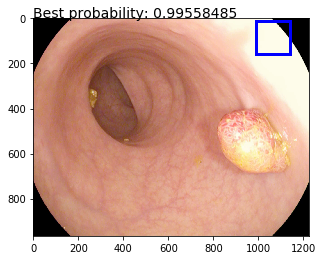

In [34]:
print('Best prediction:', max_box, max_pred)
plt.figure()
plt.imshow(img)
plt.text(1, -5, 'Best probability: '+str(max_pred), fontsize=14)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((max_box[1], max_box[0]), 150, 150,linewidth=3,edgecolor='b',facecolor='none'))
plt.show()
